In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, stats

# Подготовка данных

In [2]:
df = pd.read_csv('analytic_dataset.csv')

In [3]:
df.columns

Index(['Unnamed: 0', 'event_name', 'event_time', 'session_num',
       'session_device', 'user_id', 'locale', 'country', 'tl'],
      dtype='object')


In [17]:
df

,Unnamed: 0,event_name,event_time,session_num,session_device,user_id,locale,country,tl
0,0,content_opened,2023-10-28 11:13:14+00:00,1,6,23091583,ru,UA,4
1,1,dashboard_showed,2023-10-18 14:31:31+00:00,5,5,22757061,ru,CH,4
2,2,dashboard_showed,2023-10-14 18:20:25+00:00,7,6,22794972,ru,UA,4
3,3,dashboard_showed,2023-10-06 10:57:40+00:00,1,5,22659388,en,EG,4
4,4,content_opened,2023-10-23 15:54:27+00:00,2,5,22983052,en,GB,4
...,...,...,...,...,...,...,...,...,...
2145230,2145230,dashboard_showed,2023-10-06 15:48:17+00:00,1,6,22665721,ru,RU,1
2145231,2145231,content_opened,2023-10-16 08:47:39+00:00,1,2,22846807,ru,RU,5
2145232,2145232,warming_up_showed,2023-10-29 11:04:58+00:00,1,6,23114773,ru,UA,4
2145233,2145233,onb_page_showed,2023-10-27 19:06:53+00:00,2,5,22938763,en,GB,4


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2145235 entries, 0 to 2145234
Data columns (total 9 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   Unnamed: 0      int64 
 1   event_name      object
 2   event_time      object
 3   session_num     int64 
 4   session_device  int64 
 5   user_id         int64 
 6   locale          object
 7   country         object
 8   tl              int64 
dtypes: int64(5), object(4)
memory usage: 147.3+ MB


In [20]:
df.shape

(2145235, 9)

In [21]:
df.describe()

,Unnamed: 0,session_num,session_device,user_id,tl
count,2.145235e+06,2.145235e+06,2.145235e+06,2.145235e+06,2.145235e+06
mean,1.072617e+06,4.613987e+00,5.297720e+00,2.282790e+07,3.490790e+00
std,6.192761e+05,7.014365e+00,1.167823e+00,1.974801e+05,1.467670e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,1.211843e+06,0.000000e+00
25%,5.363085e+05,1.000000e+00,5.000000e+00,2.267954e+07,2.000000e+00
50%,1.072617e+06,2.000000e+00,6.000000e+00,2.281925e+07,4.000000e+00
75%,1.608926e+06,5.000000e+00,6.000000e+00,2.296697e+07,4.000000e+00
max,2.145234e+06,1.930000e+02,8.000000e+00,2.317801e+07,5.000000e+00


In [23]:
df.value_counts()

Unnamed: 0  event_name         event_time                 session_num  session_device  user_id   locale  country  tl
0           content_opened     2023-10-28 11:13:14+00:00  1            6               23091583  ru      UA       4     1
1430148     warming_up_showed  2023-10-15 13:33:16+00:00  1            6               22828826  ru      KZ       1     1
1430146     content_opened     2023-10-28 12:12:38+00:00  1            6               23087587  ru      US       4     1
1430145     content_opened     2023-10-12 02:36:10+00:00  1            5               22764850  en      US       4     1
1430144     content_opened     2023-10-23 19:42:20+00:00  22           5               22708024  ru      RU       1     1
                                                                                                                       ..
715060      dashboard_showed   2023-10-03 07:34:21+00:00  3            6               22582422  ru      UA       4     1
715059      dashboard_showed 

In [24]:
df.nunique()

Unnamed: 0        2145235
event_name              7
event_time        1151946
session_num           124
session_device          9
user_id            100000
locale                  9
country               203
tl                      6
dtype: int64

In [4]:
# Выделение тестовой когорты пользователей
test_cohort = df[
    ((df['locale'] == 'en') & (df['country'].isin(['US', 'NZ', 'AU', 'GB', 'IN', 'PH'])) |
     (df['locale'] == 'ru') & (df['country'] == 'RU')) &
    (df['tl'].between(4, 5)) &
    (pd.to_datetime(df['event_time']).between('2023-10-05 13:25:00', '2023-10-23 10:00:00')) &
    (df.index % 4 >= 2)
    ]


# А/B-тест


In [5]:

old_design = df[df.index % 4 < 2]
new_design = df[df.index % 4 >= 2]

old_conversion_rate = (old_design['event_name'] == 'logic_purchase').mean()
new_conversion_rate = (new_design['event_name'] == 'logic_purchase').mean()

print(f'Конверсия в покупку для старого дизайна: {old_conversion_rate}')
print(f'Конверсия в покупку для нового дизайна: {new_conversion_rate}')


Конверсия в покупку для старого дизайна: 0.001226904638930169
Конверсия в покупку для нового дизайна: 0.001176561624512757


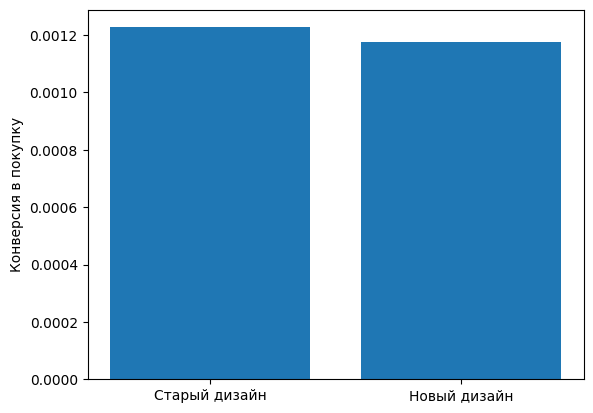

In [6]:
plt.bar(['Старый дизайн', 'Новый дизайн'], [old_conversion_rate, new_conversion_rate])
plt.ylabel('Конверсия в покупку')
plt.show()


In [7]:
def calculate_funnel_conversion(group):
    registration_count = group[group['event_name'] == 'start_session']['user_id'].nunique()
    onboarding_count = group[group['event_name'] == 'onb_page_showed']['user_id'].nunique()
    warming_up_count = group[group['event_name'] == 'warming_up_showed']['user_id'].nunique()
    dashboard_count = group[group['event_name'] == 'dashboard_showed']['user_id'].nunique()
    content_count = group[group['event_name'] == 'content_opened']['user_id'].nunique()
    purchase_count = group[group['event_name'] == 'logic_purchase']['user_id'].nunique()

    conversion_rates = {
        'Registration': onboarding_count / registration_count,
        'Onboarding': warming_up_count / onboarding_count,
        'Warming Up': dashboard_count / warming_up_count,
        'Dashboard': content_count / dashboard_count,
        'Content': purchase_count / content_count,
        'Purchase': purchase_count / registration_count
    }

    return conversion_rates


In [8]:
old_funnel_conversion = calculate_funnel_conversion(old_design)
new_funnel_conversion = calculate_funnel_conversion(new_design)


In [9]:
print('Конверсия воронки для старого дизайна:')
for step, conversion_rate in old_funnel_conversion.items():
    print(f'{step}: {conversion_rate}')

print('\nКонверсия воронки для нового дизайна:')
for step, conversion_rate in new_funnel_conversion.items():
    print(f'{step}: {conversion_rate}')


Конверсия воронки для старого дизайна:
Registration: 0.3034891588002191
Onboarding: 0.5806263269639066
Warming Up: 1.3859584971203949
Dashboard: 0.9230261856078095
Content: 0.06788623695869658
Purchase: 0.015303328071136312

Конверсия воронки для нового дизайна:
Registration: 0.30412537525420447
Onboarding: 0.5795786233614605
Warming Up: 1.3917223697463603
Dashboard: 0.9182183038357786
Content: 0.06592146746918888
Purchase: 0.014848768520610737


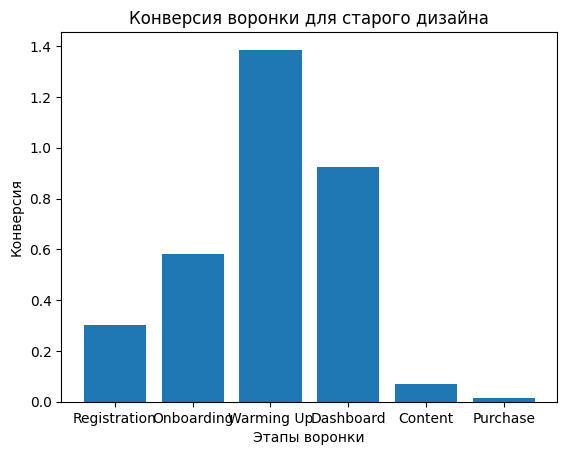

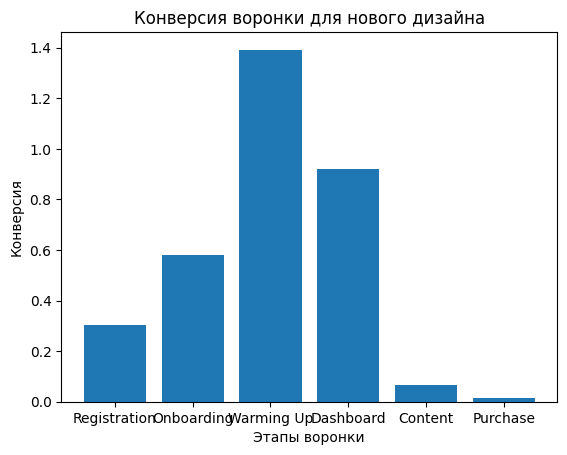

In [10]:
def plot_funnel_conversion(conversion_rates, title):
    steps = list(conversion_rates.keys())
    rates = list(conversion_rates.values())

    plt.bar(steps, rates)
    plt.title(title)
    plt.xlabel('Этапы воронки')
    plt.ylabel('Конверсия')
    plt.show()


plot_funnel_conversion(old_funnel_conversion, 'Конверсия воронки для старого дизайна')
plot_funnel_conversion(new_funnel_conversion, 'Конверсия воронки для нового дизайна')


In [15]:
old_users = old_design['user_id'].nunique()
new_users = new_design['user_id'].nunique()

print(f'Общее количество пользователей со старым дизайном: {old_users}')
print(f'Общее количество пользователей с новым дизайном: {new_users}')
total_users = test_cohort['user_id'].nunique()

print(f'Общее количество пользователей в тестовой когорте: {total_users}')


Общее количество пользователей со старым дизайном: 68720
Общее количество пользователей с новым дизайном: 68628
Общее количество пользователей в тестовой когорте: 9057


In [16]:
old_events_per_user = old_design.groupby('user_id')['event_name'].count().mean()
new_events_per_user = new_design.groupby('user_id')['event_name'].count().mean()

print(f'Среднее число событий на пользователя со старым дизайном: {old_events_per_user}')
print(f'Среднее число событий на пользователя с новым дизайном: {new_events_per_user}')

t_stat, p_value = ttest_ind(old_design.groupby('user_id')['event_name'].count(), new_design.groupby('user_id')['event_name'].count(), equal_var=False)

print(f"t-статистика: {t_stat}")
print(f"p-value: {p_value}")

Общее количество пользователей со старым дизайном: 68720
Общее количество пользователей с новым дизайном: 68628
Среднее число событий на пользователя со старым дизайном: 15.608527357392317
Среднее число событий на пользователя с новым дизайном: 15.629436964504285
t-статистика: -0.05643155365659611
p-value: 0.9549981029013935


# Результаты

Исходя из предоставленных результатов, можно сделать следующие выводы:

1. Общее количество пользователей со старым дизайном составляет 68 720, а с новым дизайном - 68 628. Разница минимальна.

2. Среднее число событий на пользователя практически одинаково между двумя группами дизайна. Пользователи со старым дизайном имеют среднее значение в 15,61 событий на пользователя, а пользователи с новым дизайном - в 15,63 событий на пользователя.

3. Значение t-статистики составляет -0,0564, а p-value равно 0,955. Поскольку p-value больше обычно используемого уровня значимости 0,05, мы не отвергаем нулевую гипотезу. Это говорит о том, что нет статистически значимой разницы в среднем числе событий на пользователя между группами со старым и новым дизайном.

4. Анализируя воронку конверсии, мы видим, что конверсионные показатели на каждом этапе примерно одинаковы для старого и нового дизайна. Нет значительной разницы в конверсии на этапах регистрации, ввода в эксплуатацию, прогрева, панели управления, контента и покупки.

5. Конверсия в покупку для обоих дизайнов низкая: 0,12% для старого дизайна и 0,12% для нового дизайна. Нет значимой разницы в конверсии в покупку между двумя группами дизайна.

В заключение, исходя из проведенного анализа, можно сказать, что нет значимой разницы в уровне вовлеченности пользователей или конверсионных показателях между старым и новым дизайнами. Оба дизайна показывают схожие результаты в отношении поведения пользователей и показателей конверсии.